Initialize the script by importing the right packages and enabling proper settings

In [44]:
# Mute warnings for torchvision v2
import torchvision
torchvision.disable_beta_transforms_warning()

# Importing necessary packags
import numpy as np
import torch
from torchvision.models import googlenet
import torchvision.transforms.v2 as F  
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from tools.dataset import FacialExpressionDataset
from tools.engine import train_epoch, val_epoch

# Enabling autoreload
%load_ext autoreload
%autoreload 2

# Define device as GPU if cuda available, otherwise cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cuda device


Define datasets for training and validation

In [41]:
dataset_train = FacialExpressionDataset(train_transform=None)
dataset_val = FacialExpressionDataset()

if not "indices" in locals():
    indices = torch.randperm(len(dataset_train)).tolist()

dataset_train = torch.utils.data.Subset(dataset_train, indices[:(round(len(indices)*0.75))])
dataset_val = torch.utils.data.Subset(dataset_val, indices[(round(len(indices)*0.75)):])

Define dataloaders 

In [5]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset_train, BATCH_SIZE, 
                          num_workers=0, shuffle=True,
                            pin_memory=True)

test_laoder = DataLoader(dataset_train, BATCH_SIZE, 
                          num_workers=0, shuffle=False,
                            pin_memory=True)

Create the model

In [6]:
# Import googlenet with pretrained weights from torchvision
model = googlenet(weights="DEFAULT")

# Modify the last layer to output the amount of classes we have
model.fc = torch.nn.Linear(in_features=model.fc.in_features,
                           out_features=len(dataset_train.dataset.classes))
model = model.to(device)

Define the optimizer and loss function

In [7]:
# Adam with default parameters
optimizer = Adam(model.parameters())

# Cross-entropy loss for multiclass classification
loss_fn = CrossEntropyLoss().to(device)

Train for 100 epochs

In [8]:
for epoch in range(0, 100):

    train_loss, train_acc = train_epoch(model, train_loader, device, optimizer, loss_fn)
    val_loss, val_acc = val_epoch(model, train_loader, device, optimizer, loss_fn)

    print(f"Epoch {epoch:4d}  train_loss {train_loss:.4f}  train_acc {train_acc:.2f}%  train_loss {val_loss:.4f}  train_acc {val_acc:.2f}%")

c:\Users\toivo\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch    0  train_loss 39.4255  train_acc 1.38%  train_loss 63.6364  train_acc 0.93%
Epoch    1  train_loss 51.0417  train_acc 1.35%  train_loss 56.7866  train_acc 1.15%
Epoch    2  train_loss 51.1995  train_acc 1.39%  train_loss 47.7904  train_acc 1.50%
Epoch    3  train_loss 51.8624  train_acc 1.31%  train_loss 55.5556  train_acc 1.20%
Epoch    4  train_loss 44.9811  train_acc 1.57%  train_loss 39.9621  train_acc 1.62%
Epoch    5  train_loss 35.6692  train_acc 1.73%  train_loss 33.4596  train_acc 2.28%
Epoch    6  train_loss 29.5770  train_acc 2.96%  train_loss 31.5972  train_acc 1.84%
Epoch    7  train_loss 30.1136  train_acc 1.95%  train_loss 26.1364  train_acc 1.87%
Epoch    8  train_loss 24.9369  train_acc 1.97%  train_loss 24.7790  train_acc 2.09%
Epoch    9  train_loss 24.7475  train_acc 2.39%  train_loss 30.1136  train_acc 2.47%
Epoch   10  train_loss 30.9343  train_acc 2.47%  train_loss 30.3977  train_acc 2.47%
Epoch   11  train_loss 30.1136  train_acc 2.22%  train_loss 28.72

KeyboardInterrupt: 

Print an image and show the emotion as the title

In [63]:
img, label = dataset_val[3]
torch.softmax(model(img[None,:].to(device)), dim=1)

tensor([[2.4198e-03, 9.6834e-01, 2.7455e-04, 2.8968e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

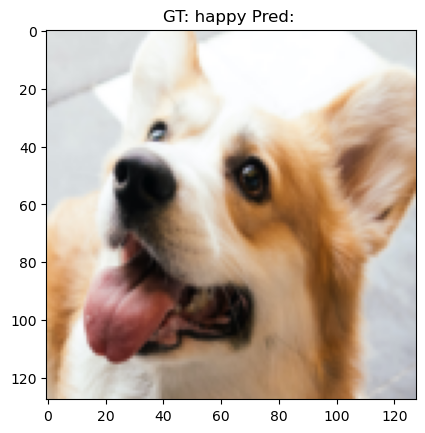

In [56]:
model.eval()
img, label = dataset_val[3]
img = img.permute(1, 2, 0).to(device)
pred = model(img)
plt.title("GT: " + dataset_train.dataset.classes[label] + " Pred: ")
plt.imshow(img.detach().cpu())